<a href="https://colab.research.google.com/github/ArthurChen189/ML/blob/master/Copy_of_Copy_of_Ada_Opt_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison between Adam, AdaBoost, and AdaFactor

*Scott Hawley*

In this notebook, we'll compare the performance of Adam against two recent modifications, AdaBoost and AdaFactor. 

To do so, we'll use two different problem-examples:

1. XOR with a MLP network
2. MNIST with a CNN

## Preliminaries: Load modules, define both AdaBound and AdaFactor

In [0]:
import numpy as np
import torch   
import math
import torch
from torch.optim import Optimizer
import operator
import functools
from copy import copy
from math import sqrt
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


class AdaBound(Optimizer):
    """  AdaBound code from https://github.com/Luolc/AdaBound/blob/master/adabound/adabound.py
    Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss


      

class AdaFactor(torch.optim.Optimizer):
    """
    AdaFactor code from https://github.com/DeadAt0m/adafactor-pytorch/blob/master/adafactor.py
    """
    def __init__(self, params, lr=None, beta1=0.9, beta2=0.999, eps1=1e-30,
                 eps2=1e-3, cliping_threshold=1,non_constant_decay = True,
                 enable_factorization=True, ams_grad=True, weight_decay=0):

        enable_momentum =  beta1 != 0
        self.beta1_glob = copy(beta1)
        self.beta2_glob = copy(beta2)
        self.lr_glob = copy(lr)

        beta1 = self.beta1_glob if hasattr(beta1,'__call__') else lambda x: self.beta1_glob
        beta2 = self.beta2_glob if hasattr(beta2,'__call__') else lambda x: self.beta2_glob

        if non_constant_decay:
            ams_grad = False
            if isinstance(self.beta1_glob,float):
                beta1 = lambda t: self.beta1_glob * (1 - self.beta1_glob ** (t-1)) / (1 - self.beta1_glob ** t)
            if isinstance(self.beta2_glob,float):
                beta2 = lambda t: self.beta2_glob * (1 - self.beta2_glob ** (t-1)) / (1 - self.beta2_glob ** t)

        relative_step_size  = True

        if lr is None:
            #default value from article
            lr = lambda t: min(1e-2, 1 / sqrt(t))

        if isinstance(self.lr_glob, float):
            lr=lambda x: self.lr_glob
            relative_step_size = False


        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps1=eps1,
                        eps2=eps2, cliping_threshold=cliping_threshold,                                                                                 weight_decay=weight_decay,ams_grad=ams_grad,
                        enable_factorization=enable_factorization,
                        enable_momentum=enable_momentum,relative_step_size=relative_step_size)

        super(AdaFactor, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdaFactor, self).__setstate__(state)

    def _experimental_reshape(self,shape):
        temp_shape = shape[2:]
        if len(temp_shape) == 1:
            new_shape = (shape[0],shape[1]*shape[2])
        else:
            tmp_div = len(temp_shape) // 2 + len(temp_shape) % 2
            new_shape = (shape[0]*functools.reduce(operator.mul, temp_shape[tmp_div:],1),
                         shape[1]*functools.reduce(operator.mul, temp_shape[:tmp_div],1))
        return new_shape, copy(shape)


    def _check_shape(self, shape):
        '''
        output1 - True - algorithm for matrix, False - vector;
        output2 - need reshape
        '''
        if len(shape) > 2:
            return True, True
        elif len(shape) == 2:
            return True, False
        elif len(shape) == 2 and (shape[0] == 1 or shape[1] == 1):
            return False, False
        else:
            return False, False

    def _rms(self, x):
        return sqrt(torch.mean(x.pow(2)))



    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data


                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                is_matrix, is_need_reshape = self._check_shape(grad.size())
                new_shape = p.data.size()
                if is_need_reshape and group['enable_factorization']:
                    new_shape, old_shape =\
                    self._experimental_reshape(p.data.size())
                    grad = grad.view(new_shape)

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    if group['enable_momentum']:
                        state['exp_avg'] = torch.zeros(new_shape, dtype=torch.float32, device=p.grad.device)


                    if is_matrix and group['enable_factorization']:
                        state['exp_avg_sq_R'] = torch.zeros((1,new_shape[1]), dtype=torch.float32, device=p.grad.device)
                        state['exp_avg_sq_C'] = torch.zeros((new_shape[0],1), dtype=torch.float32, device=p.grad.device)
                    else:
                        state['exp_avg_sq'] = torch.zeros(new_shape, dtype=torch.float32, device=p.grad.device)
                    if group['ams_grad']:
                        state['exp_avg_sq_hat'] = torch.zeros(new_shape, dtype=torch.float32, device=p.grad.device)


                if group['enable_momentum']:
                    exp_avg = state['exp_avg']

                if is_matrix and group['enable_factorization']:
                    exp_avg_sq_R = state['exp_avg_sq_R']
                    exp_avg_sq_C = state['exp_avg_sq_C']
                else:
                    exp_avg_sq = state['exp_avg_sq']

                if group['ams_grad']:
                    exp_avg_sq_hat = state['exp_avg_sq_hat']


                state['step'] += 1
                lr_t = group['lr'](state['step'])
                if group['relative_step_size']:
                    lr_t *= max(group['eps2'], self._rms(p.data))

                if group['enable_momentum']:
                    beta1_t = group['beta1'](state['step'])
                    exp_avg.mul_(beta1_t).add_(1 - beta1_t, grad)

                beta2_t = group['beta2'](state['step'])

                if is_matrix and group['enable_factorization']:
                    exp_avg_sq_R.mul_(beta2_t).add_(1 - beta2_t,
                      torch.sum(torch.mul(grad,grad).add_(group['eps1']), dim=0, keepdim=True))
                    exp_avg_sq_C.mul_(beta2_t).add_(1 - beta2_t,
                      torch.sum(torch.mul(grad,grad).add_(group['eps1']), dim=1, keepdim=True))
                    v = torch.mul(exp_avg_sq_C,exp_avg_sq_R).div_(torch.sum(exp_avg_sq_R))
                else:
                    exp_avg_sq.mul_(beta2_t).addcmul_(1 - beta2_t, grad, grad).add_((1 - beta2_t)*group['eps1'])
                    v = exp_avg_sq


                g = grad
                if group['enable_momentum']:
                    g = torch.div(exp_avg,1 - beta1_t ** state['step'])

                if group['ams_grad']:
                    torch.max(exp_avg_sq_hat, v, out=exp_avg_sq_hat)
                    v = exp_avg_sq_hat
                    u = torch.div(g,(torch.div(v,1 - beta2_t ** state['step'])).sqrt().add_(group['eps1']))
                else:
                    u = torch.div(g,v.sqrt())

                u.div_(max(1,self._rms(u) / group['cliping_threshold']))
                p.data.add_(-lr_t * (u.view(old_shape) if is_need_reshape and group['enable_factorization'] else u))


                if group['weight_decay'] != 0:
                    p.data.add_(-group['weight_decay'] * lr_t, p.data)

        return loss

## First Problem: VERY simply dataset: XOR
(Scroll down for MNIST)

Dataset:

In [0]:
# simple training data: XOR problem
X = np.array([[0,0],[0,1],[1,0],[1,1]],dtype=np.float32)
Y = np.array([[0,1,1,0]],dtype=np.float32).T

# re-cast data as PyTorch variables, on the device (CPU or GPU) where calc's are performed
x, y = torch.tensor(X).to(device), torch.tensor(Y).to(device)   


## Now define and run the problem:

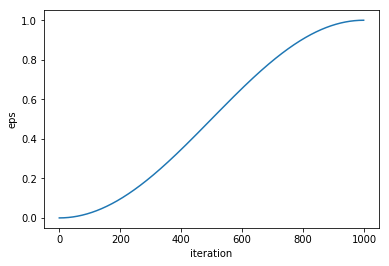

**** anneal_eps = True ****
Target answer:  [[0. 1. 1. 0.]]

---- adam
prediction = [[0.00621847 0.99699485 0.99691916 0.0023558 ]]

---- adafactor
prediction = [[2.9854513e-05 9.9997401e-01 9.9997866e-01 2.3114444e-05]]

---- adabound
prediction = [[0.00615379 0.9969813  0.9967481  0.00257945]]

---- rprop
prediction = [[2.6352084e-14 1.0000000e+00 1.0000000e+00 3.0023233e-26]]


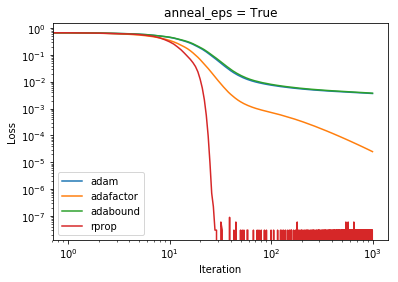

**** anneal_eps = False ****
Target answer:  [[0. 1. 1. 0.]]

---- adam
prediction = [[3.0606661e-05 9.9997222e-01 9.9997830e-01 2.4557012e-05]]

---- adafactor
prediction = [[2.9854513e-05 9.9997401e-01 9.9997866e-01 2.3114444e-05]]

---- adabound
prediction = [[1.8372489e-03 9.9916172e-01 9.9907529e-01 6.2506425e-04]]

---- rprop
prediction = [[2.6352084e-14 1.0000000e+00 1.0000000e+00 3.0023233e-26]]


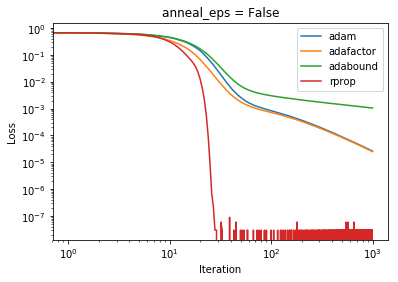

In [4]:
alpha = 0.05                       # Base learning rate

loss_fn = torch.nn.BCELoss()      # binary cross-entropy loss

maxiter = 1000                    # max number of iterations


# schedule for varying epsilon from 1e-8 to ~1 via cosine annealing
eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))
plt.plot(eps_sched)
plt.xlabel('iteration')
plt.ylabel('eps')
plt.show()



# Show the difference between annealing epsilon or not 
for anneal_eps in [True, False]:
  
    print("**** anneal_eps =",anneal_eps,"****")

    print("Target answer: ",Y.T)       # display target output as a reminder

    # Cycle through different optimizers
    for opt_choice in ['adam', 'adafactor', 'adabound', 'rprop' ]:

        torch.manual_seed(1)                    # set random seed, for reproducibility
        if torch.cuda.is_available():
            torch.cuda.manual_seed(1)

        # (re-)specify simple model
        n_hidden = 20                           # number of hidden neurons
        model = torch.nn.Sequential(
          torch.nn.Linear(X.shape[1], n_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(n_hidden, 1),
          torch.nn.Sigmoid()
          ).to(device)

        # define optimizer method based on choice in opt_choice loop 
        if 'adam' == opt_choice:
          optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=alpha)
        elif 'adafactor' == opt_choice:
          optimizer = AdaFactor([{'params': model.parameters()}], lr=alpha)
        elif 'adabound' == opt_choice:
          optimizer = AdaBound([{'params': model.parameters()}], lr=alpha)
        else:      # good old rprop dominates these others for this simple dataset
          optimizer = torch.optim.Rprop([{'params': model.parameters()}], lr=alpha)


        print(f"\n---- {opt_choice}")

        optimizer.param_groups[0]['eps'] = eps_sched[0] # initial value for eps 

        # training loop
        loss_history = []
        for itr in range(maxiter):
          optimizer.zero_grad()                  # set gradients=0 before calculating more
          y_tilde = model(x)                     # feed-forward step
          loss = loss_fn(y_tilde, y)             # compute the loss
          loss_history.append(loss.item())  # save loss for plotting later
          loss.backward()                        # compute gradients via backprop
          optimizer.step()                       # actually update the weights

          # Before next loop: anneal optimizer variables 
          if anneal_eps:
            optimizer.param_groups[0]['eps'] = eps_sched[itr]

        #print("final eps = ",optimizer.param_groups[0]['eps'])  # confirm final value is on the order of 1

        # print and plot our results
        print("prediction =", y_tilde.cpu().data.numpy().T )
        plt.loglog(loss_history,label=opt_choice)
        plt.title('anneal_eps = '+str(anneal_eps))

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

As we see above, removing the cosine-annealing on `eps` improved the performance for Adam (i.e. regular Adam works better than eps-annealed Adam), but didn't seem to have any effect on either AdaBound or AdaFactor. 

## Second Problem: MNIST

MNIST example code taken  from PyTorch example https://github.com/pytorch/examples/blob/master/mnist/main.py)

### First, load the dataset(s)...

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

batch_size = 200        
test_batch_size = 1000

train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=test_batch_size, shuffle=True)


0it [00:00, ?it/s]

9920512it [00:01, 8551208.77it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129828.41it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2150862.34it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49176.95it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Define the model and train/test procedures

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
   
  

def train(model, device, train_loader, optimizer, epoch, eps_sched, log_interval=200):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      itr = (epoch-1)*(len(train_loader.dataset)//batch_size) + batch_idx
      optimizer.param_groups[0]['eps'] = eps_sched[itr]
      
      if batch_idx % log_interval == 0:
          print('\r   Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return loss.item()
      
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('   Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss



### Perform the training

Note: A starting learing rate  of 1e-3 seems to be what many defaults assume.  if you do that (below), then AdaFactor seems to "win."  But if you go higher, AdaFactor gets "unstable" whereas the others do not.  (AdaFactor will even produce NaNs where others don't, particularly for small batch sizes.)
Let's see that...

**** anneal_eps = True ****

---- adam
   Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307263
   Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.141741
   Test set: Average loss: 0.1122, Accuracy: 9669/10000 (96.69%)

   Train Epoch: 2 [0/60000 (0%)]	Loss: 0.150781
   Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.085650
   Test set: Average loss: 0.0964, Accuracy: 9711/10000 (97.11%)

   Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085640
   Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.157575
   Test set: Average loss: 0.0902, Accuracy: 9726/10000 (97.26%)

   Train Epoch: 4 [0/60000 (0%)]	Loss: 0.078505
   Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.060775
   Test set: Average loss: 0.0886, Accuracy: 9726/10000 (97.26%)

   Train Epoch: 5 [0/60000 (0%)]	Loss: 0.109779
   Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.123174
   Test set: Average loss: 0.0863, Accuracy: 9737/10000 (97.37%)

   Train Epoch: 6 [0/60000 (0%)]	Loss: 0.199167
   Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.054091
   Test set: Average loss

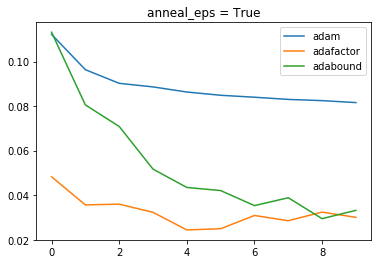

**** anneal_eps = False ****

---- adam
   Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307263
   Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.141741
   Test set: Average loss: 0.1122, Accuracy: 9669/10000 (96.69%)

   Train Epoch: 2 [0/60000 (0%)]	Loss: 0.150781
   Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.085650
   Test set: Average loss: 0.0964, Accuracy: 9711/10000 (97.11%)

   Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085640
   Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.157575
   Test set: Average loss: 0.0902, Accuracy: 9726/10000 (97.26%)

   Train Epoch: 4 [0/60000 (0%)]	Loss: 0.078505
   Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.060775
   Test set: Average loss: 0.0886, Accuracy: 9726/10000 (97.26%)

   Train Epoch: 5 [0/60000 (0%)]	Loss: 0.109779
   Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.123174
   Test set: Average loss: 0.0863, Accuracy: 9737/10000 (97.37%)

   Train Epoch: 6 [0/60000 (0%)]	Loss: 0.199167
   Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.054091
   Test set: Average los

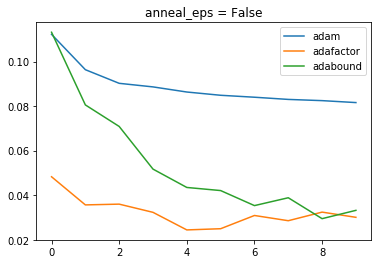

In [7]:
# The picture is completely different depending on what starting learning rate one chooses 
alpha = 1e-3     # default value. AdaFactor pretty much "wins" although arguable AdaBound does as well; Adam loses by a longshot
#alpha = 0.01    # causes AdaFactor to perform much more poorly than others. AdaBound beats Adam by a bit 

epochs = 10
maxiter = epochs*(len(train_loader.dataset)//batch_size)

eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))


for anneal_eps in [True, False]:  # with and without epsilon annealing
  
  print("**** anneal_eps =",anneal_eps,"****")

  # Cycle through different optimizers
  for opt_choice in ['adam', 'adafactor', 'adabound']:# , 'rprop' ]:

      torch.manual_seed(1)                    # set random seed, for reproducibility
      if torch.cuda.is_available():
          torch.cuda.manual_seed(1)

      print(f"\n---- {opt_choice}")

      model = Net().to(device)   # (re-)specify  model

      # define optimizer method based on choice in opt_choice loop 
      params = {'params': model.parameters()}
      if 'adam' == opt_choice:
        optimizer = torch.optim.Adam([params], lr=alpha)
      elif 'adafactor' == opt_choice:
        optimizer = AdaFactor([params], lr=alpha)
      elif 'adabound' == opt_choice:
        optimizer = AdaBound([params], lr=alpha)
      else:      
        optimizer = torch.optim.Rprop([params], lr=alpha) # rprop is known to perform poorly on mini-batched data

      loss_hist, vloss_hist = [], []
      for epoch in range(1, epochs + 1):
          loss_hist.append( train(model, device, train_loader, optimizer, epoch, eps_sched) )
          vloss_hist.append( test(model, device, test_loader) ) 

      plt.plot(vloss_hist,label=opt_choice)  # plot the validation loss over time
      plt.title('anneal_eps = '+str(anneal_eps))

  plt.legend()
  plt.show()

For either choice of starting learning rate, it's hard to detect any difference between anneling or not annealing the eps parameter.  Even for Adam, it doesn't seem to have a noticeable effect. 